# Periodic homogenization of linear elasticity {far}`star`

Objectives  
This tour will show how to perform periodic homogenization of linear elastic heterogeneous materials. In particular, we show how to define periodic boundary conditions and compute the effective stiffness tensor.

Attention  
This tour requires the `dolfinx_mpc` add-on package to enforce periodic boundary conditions. More details and installation instructions are to be found here https://github.com/jorgensd/dolfinx_mpc.

Download sources
* {Download}`Python script<./periodic_elasticity.py>`
* {Download}`Jupyter notebook<./periodic_elasticity.ipynb>`

The considered 2D plane strain problem deals with a skewed unit cell of dimensions $1\times \sqrt{3}/2$ consisting of circular inclusions (numbered `2`) of radius $R$ with elastic properties $(E_r, \nu_r)$ and embedded in a matrix material (numbered `1`) of properties $(E_m, \nu_m)$ following an hexagonal pattern. A classical result of homogenization theory ensures that the resulting overall behavior will be isotropic, a property that will be numerically verified later.

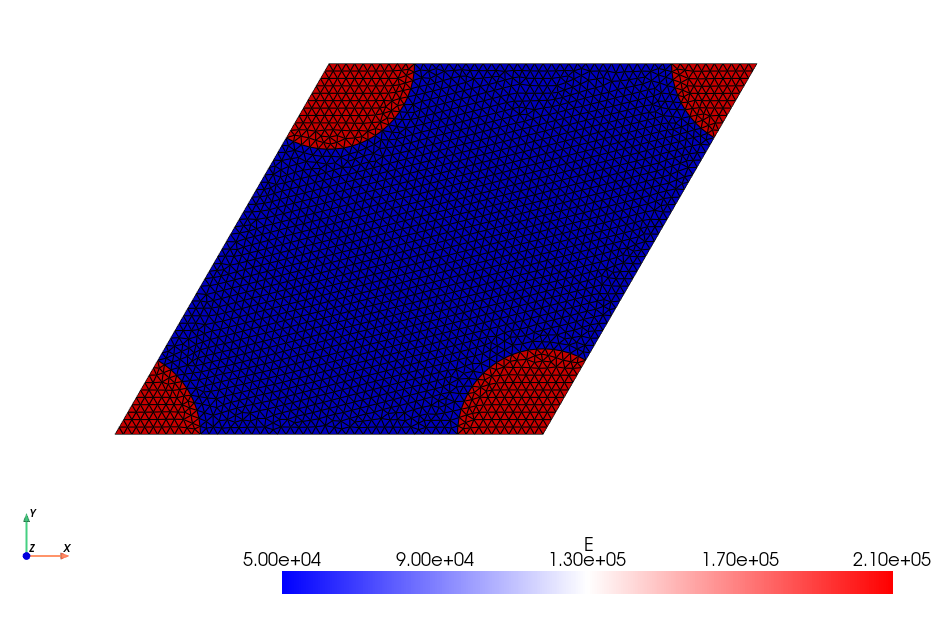

## Periodic homogenization framework

The goal of homogenization theory consists in computing the apparent elastic moduli of the homogenized medium associated with a given microstructure. In a linear elastic setting, this amounts to solving the following auxiliary problem defined on the unit cell $\mathcal{A}$:

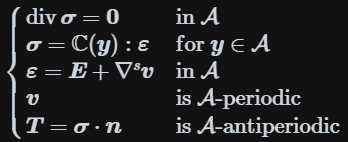

where $\boldsymbol{E}$ is the **given** macroscopic strain, $\boldsymbol{v}$ a periodic fluctuation and $\mathbb{C}(\boldsymbol{y})$ is the heterogeneous elasticity tensor depending on the microscopic space variable $\boldsymbol{y}\in\mathcal{A}$. By construction, the local microscopic strain is equal on average to the macroscopic strain: $\langle \boldsymbol{\varepsilon} \rangle = \boldsymbol{E}$. Upon defining the macroscopic stress $\boldsymbol{\Sigma}$ as the microscopic stress average: $\langle \boldsymbol{\sigma} \rangle = \boldsymbol{\Sigma}$, there will be a linear relationship between the auxiliary problem loading parameters $\boldsymbol{E}$ and the resulting average stress:

$$\boldsymbol{\Sigma}  = \mathbb{C}^\text{hom}:\boldsymbol{E}$$

where $\mathbb{C}^\text{hom}$ represents the apparent elastic moduli of the homogenized medium. Hence, its components can be computed by solving elementary load cases corresponding to the different components of $\boldsymbol{E}$ and performing a unit cell average of the resulting microscopic stress components.

### Total displacement as the main unknown

The previous problem can also be reformulated by using the total displacement $\boldsymbol{u} = \boldsymbol{E}\cdot\boldsymbol{y} + \boldsymbol{v}$ as the main unknown with now $\boldsymbol{\varepsilon} = \nabla^s \boldsymbol{u}$. The periodicity condition is therefore equivalent to the following constraint:

$$\boldsymbol{u}(\boldsymbol{y}^+)-\boldsymbol{u}(\boldsymbol{y}^-) = \boldsymbol{E}\cdot(\boldsymbol{y}^+-\boldsymbol{y}^-)$$

where $\boldsymbol{y}^{\pm}$ are opposite points on the unit cell boundary related by the periodicity condition. This formulation is widely used in solid mechanics FE software as it does not require specific change of the problem formulation but just adding tying constraints between some degrees of freedom.

This formulation is however not the easiest to deal with in `dolfinx_mpc`.

### Periodic fluctuation as the main unknown

Instead, we will keep the initial formulation and consider the periodic fluctuation $\boldsymbol{v}$ as the main unknown. The periodicity constraint on $\boldsymbol{v}$ will be imposed using the `create_periodic_constraint` functions of `dolfinx_mpc`. To do so, one must define the periodic map linking the different unit cell boundaries i.e. the right part is mapped onto the left part, the top part onto the bottom part.

## Implementation

### Mesh generation

Here the unit cell is 2D and its boundary is represented by a parallelogram of vertices ``corners`` and the corresponding base vectors `a1` and `a2` are computed. The right part is then mapped onto the left part, the top part onto the bottom part and the top-right corner onto the bottom-left one.

In [ ]:
all = []

In [ ]:
import numpy as np
from mpi4py import MPI
import gmsh
import ufl
from dolfinx import fem, io
import dolfinx.fem.petsc
from dolfinx.io.gmshio import model_to_mesh
import dolfinx_mpc.utils
from dolfinx_mpc import LinearProblem

Lx = 1.0
Ly = np.sqrt(3) / 2.0 * Lx
c = 0.5 * Lx
R = 0.2 * Lx
h = 0.02 * Lx

corners = np.array([[0.0, 0.0], [Lx, 0.0], [Lx + c, Ly], [c, Ly]])
a1 = corners[1, :] - corners[0, :]  # first vector generating periodicity
a2 = corners[3, :] - corners[0, :]  # second vector generating periodicity

The geometry is then generated using `gmsh` Python API and the Open Cascade kernel. We tag the matrix with tag `1` and the inclusions with tag `2`. The bottom, right, top and left boundaries are respectively tagged `1, 2, 3, 4`.

In [ ]:
gdim = 2  # domain geometry dimension
fdim = 1  # facets dimension
gmsh.initialize()

occ = gmsh.model.occ
mesh_comm = MPI.COMM_WORLD
model_rank = 0
if model_rank == 0:
    points = [occ.add_point(*corner, 0) for corner in corners]
    lines = [occ.add_line(points[i], points[(i + 1) % 4]) for i in range(4)]
    loop = occ.add_curve_loop(lines)
    unit_cell = occ.add_plane_surface([loop])
    inclusions = [occ.add_disk(*corner, 0, R, R) for corner in corners]
    vol_dimTag = (gdim, unit_cell)
    out = occ.intersect(
        [vol_dimTag], [(gdim, incl) for incl in inclusions], removeObject=False
    )
    incl_dimTags = out[0]
    occ.synchronize()
    occ.cut([vol_dimTag], incl_dimTags, removeTool=False)
    occ.synchronize()

    # tag physical domains and facets
    gmsh.model.addPhysicalGroup(gdim, [vol_dimTag[1]], 1, name="Matrix")
    gmsh.model.addPhysicalGroup(
        gdim,
        [tag for _, tag in incl_dimTags],
        2,
        name="Inclusions",
    )
    gmsh.model.addPhysicalGroup(fdim, [7, 20, 10], 1, name="bottom")
    gmsh.model.addPhysicalGroup(fdim, [9, 19, 16], 2, name="right")
    gmsh.model.addPhysicalGroup(fdim, [15, 18, 12], 3, name="top")
    gmsh.model.addPhysicalGroup(fdim, [11, 17, 5], 4, name="left")
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", h)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", h)

    gmsh.model.mesh.generate(gdim)

domain, cells, facets = model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=gdim)
gmsh.finalize()

We compute the unit cell volume from the mesh for verification:

In [ ]:
vol = fem.assemble_scalar(fem.form(1 * ufl.dx(domain=domain)))
print("Volume:", vol)

### Variational formulation with heterogeneous material properties

In the [legacy demo](https://comet-fenics.readthedocs.io/en/latest/demo/periodic_homog_elas/periodic_homog_elas.html), the variational formulation made use of two different terms in the bilinear form using `dx(1)` and `dx(2)` cell measures representing the contribution of both phases to the global weak form. This approach is not necessarily well adapted to more complex types of heterogeneities such as the case with a large number of phases with different properties or phases with spatially-dependent properties. As an alternative, we thus consider a single constitutive law expression for all phases but with material properties (Young modulus and Poisson ratio) being represented as functions defined on the mesh. In this case, we use piecewise constant (`DG0`) functions with constant value on the matrix and on the inclusion phases. To easily set up such fields we define the function `create_piecewise_constant_field` to generate scalar `DG0` functions using a dictionary mapping phase labels to values, see [](/tips/piecewise_constant_field/piecewise_constant_field.md).  If needed, such a helper function could be generalized to vector or tensor-valued functions.

In [ ]:
def create_piecewise_constant_field(domain, cell_markers, property_dict, name=None):
    """Create a piecewise constant field with different values per subdomain.

    Parameters
    ----------
    domain : Mesh
        `dolfinx` mesh object
    cell_markers : MeshTag
        cell marker MeshTag
    property_dict : dict
        A dictionary mapping region tags to physical values {tag: value}

    Returns
    -------
    A DG-0 function
    """
    V0 = fem.functionspace(domain, ("DG", 0))
    k = fem.Function(V0, name=name)
    for tag, value in property_dict.items():
        cells = cell_markers.find(tag)
        k.x.array[cells] = np.full_like(cells, value, dtype=np.float64)
    return k


E = create_piecewise_constant_field(
    domain, cells, {1: 50e3, 2: 210e3}, name="YoungModulus"
)
nu = create_piecewise_constant_field(
    domain, cells, {1: 0.2, 2: 0.3}, name="PoissonRatio"
)

lmbda = E * nu / (1 + nu) / (1 - 2 * nu)
mu = E / 2 / (1 + nu)

As discussed before, our main unknown is the periodic fluctuation $\bv$. The loading will be imposed by the macroscopic strain $\bE$ which we define as a `fem.Constant`. We will then be able to rebuild the total displacement $\bu = \bE\cdot\by + \bv$ using the `ufl.SpatialCoordinate`. Below we define the variational form. Note that `ufl.inner(sigma(du), epsilon(u_)) * ufl.dx` contains both bilinear and linear terms, the latter being due to the presence of the macroscopic strain $\bE$ acting as an external loading. We make use of `ufl.system` to split the form into a bilinear and linear form.

In [ ]:
Eps = fem.Constant(domain, np.zeros((2, 2)))
Eps_ = fem.Constant(domain, np.zeros((2, 2)))
y = ufl.SpatialCoordinate(domain)


def epsilon(v):
    return ufl.sym(ufl.grad(v))


def sigma(v):
    eps = Eps + epsilon(v)
    return lmbda * ufl.tr(eps) * ufl.Identity(gdim) + 2 * mu * eps


V = fem.functionspace(domain, ("P", 2, (gdim,)))
du = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)
a_form, L_form = ufl.system(ufl.inner(sigma(du), epsilon(u_)) * ufl.dx)

### Periodic boundary conditions enforcement using `dolfinx_mpc`

We must now define the periodic boundary conditions for the fluctuation field. For that, we make use of `dolfinx_mpc` providing a `MultiPointConstraint` object which can account for periodicity conditions. Note that periodic conditions do not fix rigid body translations. To remove them we choose here, for simplicity, to fix the displacement of the single point of coordinate `(0, 0)`. An alternative can consist of introducing constant Lagrange multipliers as discussed in the legacy demo. This solution requires however to use `Real` elements which require special care and are currently available in the `scifem` package https://github.com/scientificcomputing/scifem.

In [ ]:
point_dof = fem.locate_dofs_geometrical(
    V, lambda x: np.isclose(x[0], 0.0) & np.isclose(x[1], 0)
)
bcs = [fem.dirichletbc(np.zeros((gdim,)), point_dof, V)]

We first instantiate the `MultiPointConstraint` object `mpc` defined with respect to our function space `V`. The function `create_periodic_constraint_topological` enables to link dofs on corresponding surfaces. We must first define a mapping between points on corresponding surfaces. For instance, we apply the first condition to the right surface, tagged `2`. The `periodic_relation_left_right` transforms input coordinates on the right surface to points on the left surface as follows: $(x, y) \mapsto (x-L_x, y)$. More generally, the mapping is $(x, y) \mapsto (x-a_{1x}, y-a_{1y})$ for the first periodicity-generating base vector $\ba_1$. We do the same for the top surface, tagged `3`, which is mapped to th
e bottom one using the second periodicity-generating base vector $\ba_2.$

In [ ]:
def periodic_relation_left_right(x):
    out_x = np.zeros(x.shape)
    out_x[0] = x[0] - a1[0]
    out_x[1] = x[1] - a1[1]
    out_x[2] = x[2]
    return out_x


def periodic_relation_bottom_top(x):
    out_x = np.zeros(x.shape)
    out_x[0] = x[0] - a2[0]
    out_x[1] = x[1] - a2[1]
    out_x[2] = x[2]
    return out_x


mpc = dolfinx_mpc.MultiPointConstraint(V)
mpc.create_periodic_constraint_topological(
    V, facets, 2, periodic_relation_left_right, bcs
)
mpc.create_periodic_constraint_topological(
    V, facets, 3, periodic_relation_bottom_top, bcs
)
mpc.finalize()

### Problem resolution

We are now in position of defining the problem instance. Note that we must use here the `LinearProblem` provided by `dolfinx_mpc` and not that of `dolfinx.fem.petsc`. The former expands upon the latter by including the `MultiPointConstraint` object in its arguments. Note also that the solution function field $\bv$, and the related total displacement $\bu$, must be built from the reduced function space object provided by `mpc.function_space` and not `V` in order to properly account for the imposed kinematic constraint.

In [ ]:
u = fem.Function(mpc.function_space, name="Displacement")
v = fem.Function(mpc.function_space, name="Periodic_fluctuation")
problem = LinearProblem(
    a_form,
    L_form,
    mpc,
    bcs=bcs,
    u=v,
    petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
)

To solve the homogenization problem, we define a list of elementary load cases representing macroscopic uniaxial tension in both $x$ and $y$ directions and uniform macroscopic shear in the $xy$ direction. For each of such elementary load case, we update the value of the macroscopic strain constant $\bE$ and solve the corresponding problem. The microscopic total displacement $\bu(\by)$ is then built from the periodic fluctuation. For each load case, we compute the different components of the macroscopic average stress $\boldsymbol{\Sigma}$. Since we considered unit load cases, the latter directly provide the components of the macroscopic effective stiffness tensor $\mathbb{C}^\text{hom}$.

In [ ]:
import pyvista
from dolfinx import plot

pyvista.set_jupyter_backend("static")


def plot_warped(u, scale=1.0, plot_mesh=False, user_callback=None, title=None):
    Vu = u.function_space
    u_topology, u_cell_types, u_geometry = plot.vtk_mesh(Vu)
    u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
    u_3D = np.zeros((u_geometry.shape[0], 3))
    u_3D[:, :2] = u.x.array.reshape(-1, 2)
    u_grid.point_data[u.name] = u_3D
    u_grid.set_active_vectors(u.name)
    warped = u_grid.warp_by_vector(u.name, factor=scale)

    plotter = pyvista.Plotter()
    plotter.window_size = (800, 300)
    plotter.add_mesh(warped)
    if plot_mesh:
        edges = warped.extract_all_edges()
        plotter.add_mesh(edges, color="k", line_width=1, opacity=0.5)
    plotter.view_xy()
    if title:
        plotter.add_text(title, font_size=14)
    plotter.show()

In [ ]:
elementary_load = [
    np.array([[1.0, 0.0], [0.0, 0.0]]),
    np.array([[0.0, 0.0], [0.0, 1.0]]),
    np.array([[0.0, 0.5], [0.5, 0.0]]),
]
load_labels = ["Exx", "Eyy", "Exy"]
dim_load = len(elementary_load)

C_hom = np.zeros((dim_load, dim_load))
for nload in range(dim_load):
    Eps.value = elementary_load[nload]
    u.interpolate(
        fem.Expression(
            ufl.dot(Eps, y), mpc.function_space.element.interpolation_points()
        )
    )

    problem.solve()
    u.x.array[:] += v.x.array[:]

    plot_warped(u, scale=0.5, plot_mesh=True, title=load_labels[nload])

    for nload_ in range(dim_load):
        Eps_.value = elementary_load[nload_]

        C_hom[nload, nload_] = (
            fem.assemble_scalar(fem.form(ufl.inner(sigma(v), Eps_) * ufl.dx)) / vol
        )

### Effective stiffness

In [ ]:
with np.printoptions(suppress=True, precision=0):
    print(C_hom)

It can first be verified that the obtained macroscopic stiffness is indeed symmetric and that the corresponding behavior is quasi-isotropic (up to the finite element discretization error). Indeed, if $\lambda^{hom} = \mathbb{C}_{xxyy}$ and $\mu^{hom} = \mathbb{C}_{xyxy}$ we have that $\mathbb{C}_{xxxx}\approx\mathbb{C}_{yyyy}\approx \mathbb{C}_{xxyy}+2\mathbb{C}_{xyxy} = \lambda^{hom}+2\mu^{hom}$.

In [ ]:
lmbda_hom = C_hom[0, 1]
mu_hom = C_hom[2, 2]
print("Isotropy check:", C_hom[0, 0], lmbda_hom + 2 * mu_hom)

```{note}
The macroscopic stiffness is not exactly symmetric because we computed it from the average stress which is not strictly verifying local equilibrium on the unit cell due to the FE discretization. A truly symmetric version can be obtained from the computation of the bilinear form for a pair of solutions to the elementary load cases.
```

We then deduce that $E^{hom} = \mu^{hom}\dfrac{3\lambda^{hom}+2\mu^{hom}}{\lambda^{hom}+\mu^{hom}}$ and $\nu^{hom} = \dfrac{\lambda^{hom}}{2(\lambda^{hom}+\mu^{hom})}$ that is:

In [ ]:
E_hom = mu_hom * (3 * lmbda_hom + 2 * mu_hom) / (lmbda_hom + mu_hom)
nu_hom = lmbda_hom / (lmbda_hom + mu_hom) / 2
print(f"Apparent Young modulus: {E_hom:.0f}")
print(f"Apparent Poisson ratio: {nu_hom:.3f}")